# Position and displacement field transforms

> Using and applying non-linear transformations with imglib2

- toc: false
- branch: master
- badges: true
- comments: true
- author: John Bogovic
- categories: [imglib2, transformation, transform, deformation, displacement ]

This post shows how to create and apply non-linear transformations with imglib2, specifically using `DisplacementFieldTransform`s and `PositionFieldTransform`s.

The last example of this post will show how to use a `PositionFieldTransform` to transform this one-dimensional signal into a two-dimensional space, forming the image below.


A 1D function | The 2D image created after transformation
:-------------------------:|:-------------------------:
![A 1D function](../images/function1d.png "A 1D Function") | ![The 2D image](../images/shellFromPfield.png "The 2D image")

First, let's set dependencies and import the classes we'll use:

In [1]:
%%loadFromPOM
<repository>
    <id>scijava.public</id>
    <url>https://maven.scijava.org/content/groups/public</url>
</repository>
<dependency>
    <groupId>net.imglib2</groupId>
    <artifactId>imglib2</artifactId>
    <version>6.0.0</version>
</dependency>
<dependency>
    <groupId>net.imglib2</groupId>
    <artifactId>imglib2-realtransform</artifactId>
    <version>4.0.0</version>
</dependency>
<dependency>
    <groupId>net.imglib2</groupId>
    <artifactId>imglib2-ij</artifactId>
    <version>2.0.0-beta-46</version>
</dependency>
<dependency>
    <groupId>org.knowm.xchart</groupId>
    <artifactId>xchart</artifactId>
    <version>3.5.4</version>
</dependency>

In [2]:
import java.util.function.*;
import java.util.stream.*;

import io.github.spencerpark.jupyter.kernel.display.common.*;
import io.github.spencerpark.jupyter.kernel.display.mime.*;

import net.imglib2.*;
import net.imglib2.view.*;
import net.imglib2.realtransform.*;
import net.imglib2.position.*;
import net.imglib2.type.numeric.real.*;
import net.imglib2.type.numeric.integer.*;
import net.imglib2.img.array.ArrayImgs;

import net.imglib2.util.*;
import net.imglib2.interpolation.randomaccess.*;
import net.imglib2.img.display.imagej.*;

import org.knowm.xchart.*;
import org.knowm.xchart.style.Styler.LegendPosition;
import org.knowm.xchart.style.markers.SeriesMarkers;

getKernelInstance().getRenderer().createRegistration(RandomAccessibleInterval.class)
        .preferring(MIMEType.IMAGE_PNG)
        .supporting(MIMEType.IMAGE_JPEG, MIMEType.IMAGE_GIF)
        .register((rai, context) -> Image.renderImage(
                ImageJFunctions.wrap(rai, rai.toString()).getBufferedImage(),
                context));

var printWriter = new PrintWriter(System.out,true);
char rarrow = '\u2192';
public static void printTformPts( RealPoint x, RealPoint y ) {
    printWriter.println( String.format("%s %s %s", x, rarrow, y));
};

# Displacement fields

A displacement field is the most common way to represent and store non-linear transformations. Imagine an image where a vector is stored at every position $\mathbf{x}$. That vector describes how much and in what direction the position $\mathbf{x}$ should be translated, or displaced.

$$ 
\begin{align}
\mathbf{x} &: \text{a position } \\
\mathbf{v}( \mathbf{x} ) &: \text{the vector at position } \mathbf{x}\\
\mathbf{x} + \mathbf{v}( \mathbf{x} ) &: \text{the output of the transformation}
\end{align}
$$

For example, let's consider an example vector field with the vector $[50, -25]$ at every position. This will be equivalent to a simple global translation and is not [the recommended way to represent a translation](https://javadoc.scijava.org/ImgLib2/net/imglib2/realtransform/Translation.html), but will be instructive thanks to its simplicity.

A [`FunctionRealRandomAccessible`](https://javadoc.scijava.org/ImgLib2/net/imglib2/position/FunctionRealRandomAccessible.html) is one way to make a image containing a constant value ([`ConstantUtils`](https://javadoc.scijava.org/ImgLib2/net/imglib2/util/ConstantUtils.html) is another way). This image can be passed directly to imglib2's `DisplacementFieldTransform`.

In [27]:
var displacementVector = new double[]{ 50, -25 };
var constantVector = new FunctionRealRandomAccessible<>( 2,
    (x, v) -> { v.setPosition( displacementVector ); },  // set the vector 
    () -> { return DoubleType.createVector( 2 ); });     // make a 2d vector

var dfieldConstant = new DisplacementFieldTransform( constantVector );

Applying the transformation to any point translates that point by the same amount $[50, -25]$ , as expected:

In [29]:
// two ways of initializing a point (0.0, 0.0)
var x = new RealPoint( 0.0, 0.0 ); // give the coordinates as arguments
var y = new RealPoint( 2 );        // give the number of dimensions as an argument

// transform x, store the result in y
dfieldConstant.apply( x, y );
// [-50,25] is transformed to [0,0]
printTformPts(x,y);

x = new RealPoint( -50, 25 );
dfieldConstant.apply( x, y );
// [-50,25] is transformed to [0,0]
printTformPts(x,y);


x = new RealPoint( Math.PI, 100000 );
dfieldConstant.apply( x, y );
// [pi, 100k] is transformed to [50+pi, 100k - 25]
printTformPts(x,y);

(0.0,0.0) → (50.0,-25.0)
(-50.0,25.0) → (0.0,0.0)
(3.141592653589793,100000.0) → (53.1415926535898,99975.0)


Let's make a slightly more interesting displacement field with four vectors - one at each corner. Our image will be:

```
----------------
|[1, 1]  [2, 2]|
|[3, 3]  [4, 4]|
----------------
```

i.e. the vector is $[3,3]$ is at position (0,1)

Our data needs to be 3D, where the first dimension holds the two vector components, and the other two hold the spatial dimensions.  We can use an [`ArrayImg`](https://javadoc.scijava.org/ImgLib2/net/imglib2/img/array/ArrayImgs.html) to store these data.

In [30]:
var dfieldData = ArrayImgs.doubles( 
    new double[]{ 1, 1, 2, 2, 3, 3, 4, 4 }, // the data
    2, 2, 2 );  // the dimensions
    
var dfieldCorners = new DisplacementFieldTransform( dfieldData );

For example, we expect the transform to take the point $[0,1]$ to $[3,4] = [0,1] + [3,3]$, and that is indeed what we see:

In [34]:
// [0,0] is transformed to [1,1] = [0,0] + [1,1]
var x = new RealPoint( 0.0, 0.0 );
var y = new RealPoint( 2 );
dfieldCorners.apply( x, y );
printTformPts( x, y );

// [1,0] is transformed to [3,2] = [1,0] + [2,2]
var x = new RealPoint( 1.0, 0.0 );
dfieldCorners.apply( x, y );
printTformPts( x, y );

// [0,1] is transformed to [3,4] = [0,1] + [3,3]
var x = new RealPoint( 0.0, 1.0 );
dfieldCorners.apply( x, y );
printTformPts( x, y );

// [1,1] is transformed to [5,5] = [1,1] + [4,4]
var x = new RealPoint( 1.0, 1.0 );
dfieldCorners.apply( x, y );
printTformPts( x, y );

(0.0,0.0) → (1.0,1.0)
(1.0,0.0) → (3.0,2.0)
(0.0,1.0) → (3.0,4.0)
(1.0,1.0) → (5.0,5.0)


What happens if we try to apply the transformation "in between" the discrete values of the array, or out-of-bounds of the array?

In [35]:
var x = new RealPoint( 0.5, 0.5 );
var y = new RealPoint( 2 );
dfieldCorners.apply( x, y );
// [0.5, 0.5] is transformed to [3.0, 3.0]
printTformPts(x,y);

var x = new RealPoint( -100, -100 );
var y = new RealPoint( 2 );
dfieldCorners.apply( x, y );
// [-100, -100] is transformed to [-99.0,-99.0]
printTformPts(x,y);

(0.5,0.5) → (3.0,3.0)
(-100.0,-100.0) → (-99.0,-99.0)


By default, linear interpolation determines the displacement within the array but off of grid values.  The nearest value on the border of the array determines the displacement outside the bounds. If instead we want nearest-neighbor interpolation and all out-of-bounds displacements to be zero it can be acheived by:

In [24]:
// interpret our 3d image as a 2d image of vectors
var vectorsFrom3D = Views.collapseReal( Views.moveAxis( dfieldData, 0, dfieldData.numDimensions() - 1 ));

// make the displacement field with custom interpolation and boundary extension
var dfieldCornersCustom = new DisplacementFieldTransform( 
    Views.interpolate(
        Views.extendZero( vectorsFrom3D ),          // zeros out-of-bounds
        new NearestNeighborInterpolatorFactory() )); // nearest-neighbor interpolation

var x = new RealPoint( 0.4, 0.4 );
var y = new RealPoint( 2 );
dfieldCornersCustom.apply( x, y );
printTformPts(x,y);

var x = new RealPoint( -100, -100 );
var y = new RealPoint( 2 );
dfieldCornersCustom.apply( x, y );
printTformPts(x,y);

(0.4,0.4) → (-44.6,-49.6)
(-100.0,-100.0) → (-100.0,-100.0)


Another common requirement is to specify the spacing and offset of the displacement field's discrete grid. For example, suppose we want the displacements above to be applied to the field of view $[-10, 10] \times [-20, 20]$ rather than the array coordinates $[0, 1] \times [0, 1]$. 

```
(-10,-20)  ------------------------------------------------  (10,-20)
           |[1,1]                                    [2,2]|
           |                                              |                                          
           |                                              |
           |                                              |
           |            (interpolated values)             |
           |                                              |
           |                                              |
           |                                              |
           |[3,3]                                    [4,4]|
(-10, 20)  ------------------------------------------------ (10,20)               
```

where the values outside the box are the coordinates of the corners.

This is possible by passing the desired spacing and offset directly to the `DisplacementFieldTransform`.

In [39]:
/*
 * the spacing and offset below map the array origin [0,0] to [-10,-20]
 * and the element at array index [1,1] to [10,20]
 */
var spacing = new double[]{ 20, 40 };
var offset = new double[]{ -10, -20 };
var dfieldCornersSpacingOffset = new DisplacementFieldTransform( dfieldData, spacing, offset );

// [-10,-20] is displaced by the vector [1,1], so goes to [-9,-19]
var x = new RealPoint( -10, -20 );
var y = new RealPoint( 2 );
dfieldCornersSpacingOffset.apply( x, y );
printTformPts( x, y );

// similarly, [10,20] is displaced by the vector [4,4], so goes to [14,24]
var x = new RealPoint( 10, 20 );
var y = new RealPoint( 2 );
dfieldCornersSpacingOffset.apply( x, y );
printTformPts( x, y );

(-10.0,-20.0) → (-9.0,-19.0)
(10.0,20.0) → (14.0,24.0)


# Transforming images

Displacement fields can also be applied to images.  First, let's open an image:

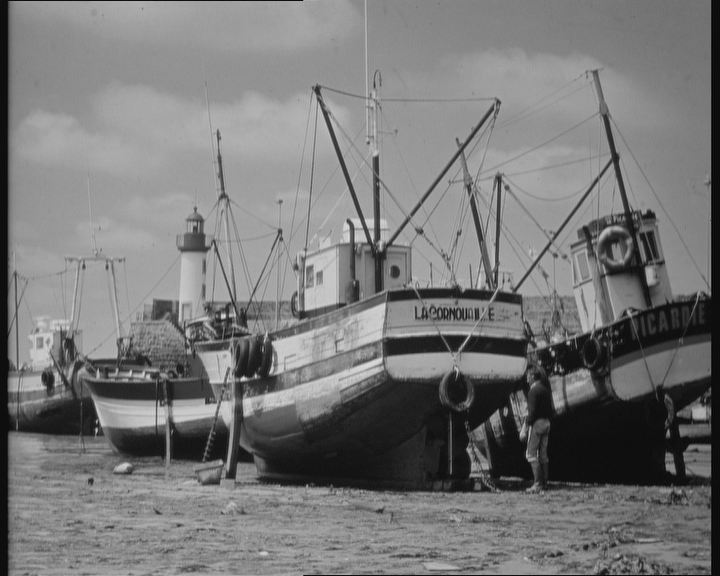

In [10]:
import ij.*;

var imp = IJ.openImage("https://mirror.imagej.net/ij/images/boats.gif");
imp.getBufferedImage();

Now let's transform it using our constant valued displacement field.  Remember this field has the vector $[50, -25]$ everwhere.

First, we'll define two functions for transforming images:

In [11]:
public RandomAccessibleInterval transformImageItvl( RandomAccessible img, RealTransform transform, Interval itvl ) {
    // interpolate the input image
    var interpImg = Views.interpolate( img, new NLinearInterpolatorFactory());
    
    // transform the image
    var transformedImg = new RealTransformRandomAccessible(interpImg, transform );
    
    // rasterize and set bounding box
    return Views.interval( Views.raster(transformedImg), itvl ) ;
}

public RandomAccessibleInterval transformImage( RandomAccessibleInterval img, RealTransform transform ) {
    // default out-of-bounds extension and output interval
    return transformImageItvl( Views.extendZero( img ), transform, img );
}

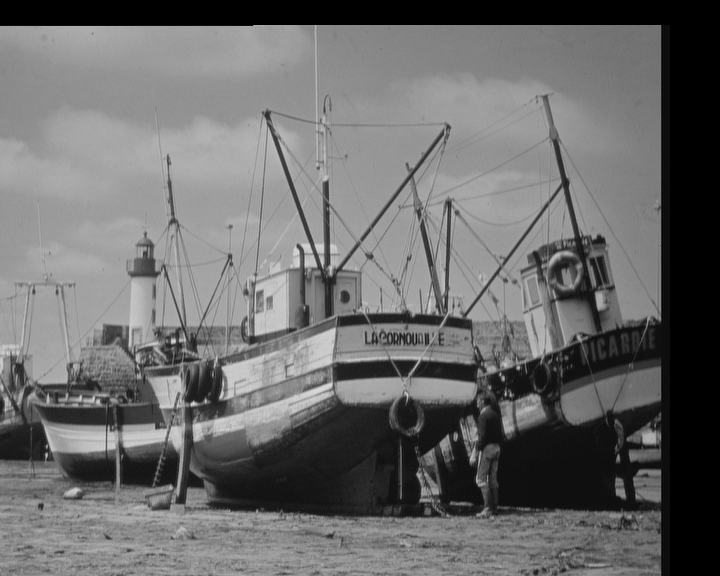

In [12]:
var imgTransformed = transformImage( ImageJFunctions.wrap( imp ), dfieldConstant );
imgTransformed

Notice that the image is shifted down (+y direction) and to the left (-x direction), has the opposite sign of the displacement vector.  This is because the "inverse" transformation (from output coordinates to input coordinates) is needed to transform images. [Learn why here](https://github.com/bogovicj/transforms_tutorial/blob/master/resources/2019_DAIS.pdf).

Now let's use what we learned above to make a displacement field whose corners are the corners of the image.

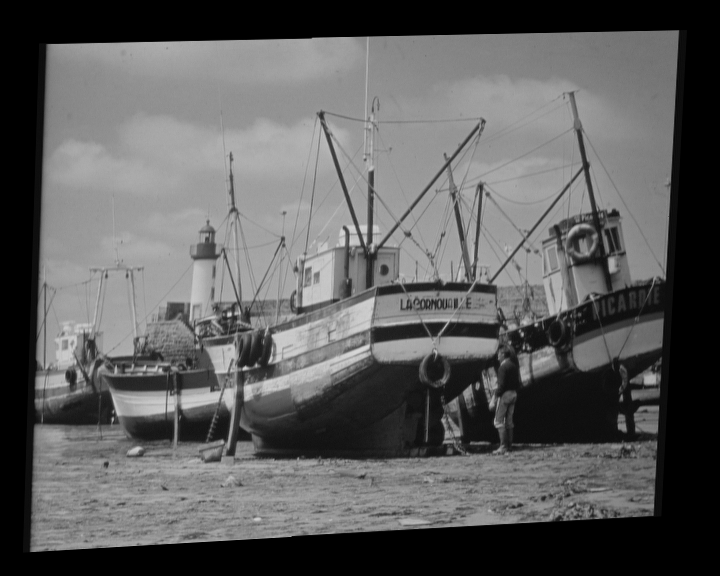

In [13]:
import net.imglib2.img.array.ArrayImgs;

// some vector field
var dfieldData = ArrayImgs.doubles( 
    new double[]{ -45, -50, 35, -35, -25, 25, 70, 75 },  // the vector data
    2, 2, 2 ); // the dimensions
    
// use the image width and height as the vector fields spacing
var dfield = new DisplacementFieldTransform( dfieldData, imp.getWidth(), imp.getHeight() );

// transform the image
var imgTransformed = transformImage( ImageJFunctions.wrap( imp ), dfield );
imgTransformed

Finally, let's make a field of random displacements at one-tenth the resolution of the image and apply it.

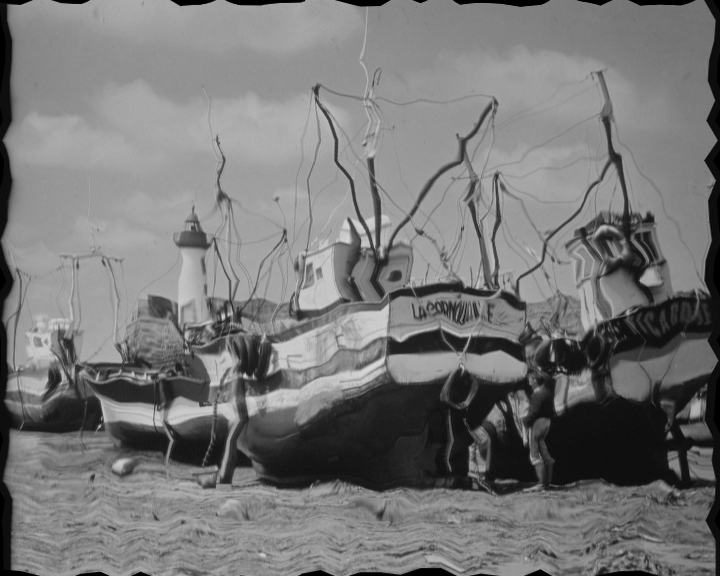

In [14]:
// create image of random vectors
var randDfieldData = ArrayImgs.doubles( 2, (long)(imp.getWidth() / 20), (long)(imp.getHeight() / 20) );
randDfieldData.forEach( x -> { x.set( 15 * ( Math.random() - 0.5) ); });
    
// spacing of 20
var dfield = new DisplacementFieldTransform( randDfieldData, 20, 20 );

// transform the image
var imgTransformed = transformImage( ImageJFunctions.wrap( imp ), dfield );
imgTransformed

# Position fields

A position, or coordinate field is similar to a displacement field in that it is also represented by a field of vectors, but those vectors represent positions directly, rather than displacements of the current position.

$$ 
\begin{align}
\mathbf{x} &: \text{a position } \\
\mathbf{v}( \mathbf{x} ) &: \text{the vector at position } \mathbf{x}\\
\mathbf{v}( \mathbf{x} ) &: \text{the output of the transformation}
\end{align}
$$

If we use a constant vector field to make a `PositionFieldTransform` the output will always be the same:

In [40]:
var coordinateVector = new double[]{ 1, 2 };
var constantVector = new FunctionRealRandomAccessible<>( 2,
    (x, v) -> { v.setPosition( displacementVector ); },  // set the vector 
    () -> { return DoubleType.createVector( 2 ); });     // make a 2d vector

var pfieldConstant = new PositionFieldTransform( constantVector );

var x = new RealPoint( 0, 0 );
var y = new RealPoint( 2 );
pfieldConstant.apply( x, y );
printTformPts(x,y);

var x = new RealPoint( 9999, 9999 );
var y = new RealPoint( 2 );
pfieldConstant.apply( x, y );
printTformPts(x,y);

(0.0,0.0) → (50.0,-25.0)
(9999.0,9999.0) → (50.0,-25.0)


The `Localizables` class has some convenience methods for producing images of coordinates. Creating a position field with this image gives the identity. `FunctionRandomAccessible`s can also be used to generate coordinate images.

x coordinates

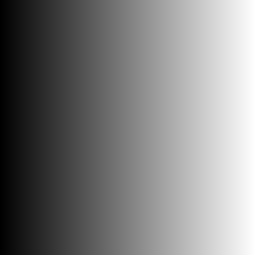

y coordinates

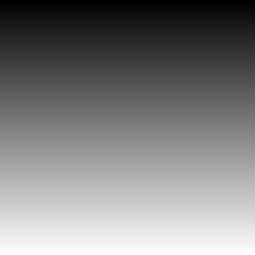

86c05009-2661-4d94-bbc3-0254741ddd31

In [41]:
var coordinates = Localizables.realRandomAccessible( 2 );

var xCoordinates = Views.interval(
    new FunctionRandomAccessible<>( 2,
        (x, v) -> { v.set( x.getIntPosition( 0 )); }, 
        () -> { return new UnsignedByteType(); }),
    new FinalInterval( 255, 255 ));

display( "x coordinates");
display( xCoordinates );
display( " ");

var yCoordinates = Views.interval(
    new FunctionRandomAccessible<>( 2,
        (x, v) -> { v.set( x.getIntPosition( 1 )); }, 
        () -> { return new UnsignedByteType(); }),
    new FinalInterval( 255, 255 ));

display( "y coordinates");
display( yCoordinates );

In [42]:
// the identity transformation
var identityPfield = new PositionFieldTransform( Localizables.realRandomAccessible( 2 ));

var x = new RealPoint( 0, 0 );
var y = new RealPoint( 2 );
identityPfield.apply( x, y );
printTformPts(x,y);

var x = new RealPoint( 9999, 9999 );
var y = new RealPoint( 2 );
identityPfield.apply( x, y );
printTformPts(x,y);

(0.0,0.0) → (0.0,0.0)
(9999.0,9999.0) → (9999.0,9999.0)


For the above examples, notice that the `identityPfield` does indeed behaves as the identity transformation.

Let's make another position field that stretches and compresses the image in a non-linear way.

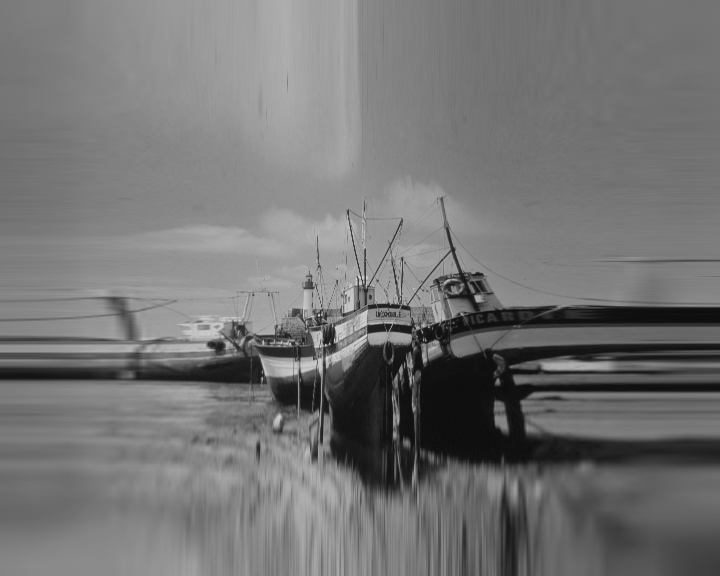

In [43]:
var pFieldVectorField = new FunctionRealRandomAccessible<>( 2,
    (p, v) -> {
        var cx = imp.getWidth() / 2.0;
        var cy = imp.getHeight() / 2.0;
        var ex = Math.exp( -0.020 * (p.getDoublePosition( 0 ) - cx ));
        var ey = Math.exp( -0.020 * (p.getDoublePosition( 1 ) - cy ));
        v.setPosition( 10 + 700 / ( 1 + ex ), 0 );
        v.setPosition( 500 / ( 1 + ey ), 1 );
    },
    () -> { return DoubleType.createVector( 2 ); });
    
// spacing of 10
var spacing = new double[]{ 1, 1 };
var offset = new double[]{ imp.getWidth() / 2.0,  imp.getHeight() / 2.0 };
var pfield = new PositionFieldTransform( pFieldVectorField );

// transform the image
var imgTransformed = transformImage( ImageJFunctions.wrap( imp ), pfield );
imgTransformed

Position fields can have different input and output dimensions. The length of the vector (first) dimension of the position field indicates its output dimension.  The domain of the field indicates the input dimension. So generally, an N+1 dimensional image has N-dimensional inputs since one dimension is the vector dimension. Let's consider an example.

In [19]:
var randPfieldData = ArrayImgs.doubles( 2, 20, 30, 40, 50 ); // make a 5d array

var pfieldRand = new PositionFieldTransform( randPfieldData );
System.out.println( "input dimensions:  " + pfieldRand.numSourceDimensions() );
System.out.println( "output dimensions: " + pfieldRand.numTargetDimensions() );

input dimensions:  4
output dimensions: 2


Let's make another example, transforming a 1D signal into a 2D space.
First, we'll make and graph a 1D signal with a `FunctionRandomAccessible`.

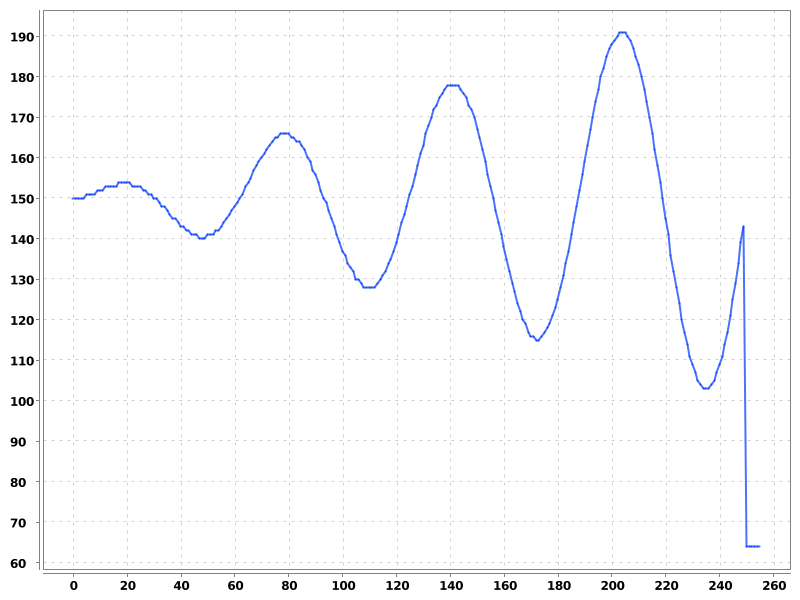

In [22]:
// a 1d signal
var sin1d = new FunctionRandomAccessible<>( 1,
    (p, v) -> {
        double t = p.getDoublePosition( 0 );
        if ( t > 250 )
            v.set(64);
        else 
            v.setReal( 150 + ( (t/5) * Math.sin( t / 10 )) );
    },
    UnsignedByteType::new );

// plot the 1d function
var xpts = new double[256];
var ypts = new double[256];

var access = sin1d.randomAccess();

IntStream.range( 0, 256 ).forEach( i -> {
    xpts[i] = i;
    access.fwd(0);
    ypts[i] = access.get().getRealDouble();
});


var chart = new XYChartBuilder().width(800).height(600).build();
chart.getStyler().setChartTitleVisible(false);
chart.getStyler().setLegendVisible(false);
chart.getStyler().setChartTitleBoxBackgroundColor( java.awt.Color.white );
chart.getStyler().setChartBackgroundColor( java.awt.Color.white );

var series = chart.addSeries("function", xpts, ypts);
series.setMarker(SeriesMarkers.NONE);

BitmapEncoder.getBufferedImage( chart )

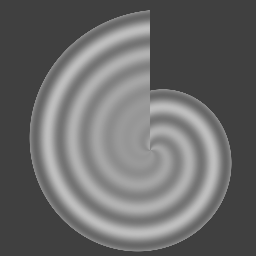

In [21]:
// create the position field (1D -> 2D)
var pFieldTransition = new PositionFieldTransform( 
    new FunctionRealRandomAccessible<>( 2, 
        ( p, v ) -> {
            double x = p.getDoublePosition( 0 ) - 150;
            double y = p.getDoublePosition( 1 ) - 150;
            double r = Math.sqrt( x*x + y*y );
            double tht = Math.atan2( x, y );
            v.setPosition( 2.5 * r +  32 * tht, 0 ); 
        }, 
        () -> { return DoubleType.createVector( 1 ); } )
);

// transform the image
var imgTransformed = transformImageItvl( sin1d, pFieldTransition, new FinalInterval( 256, 256 ));
imgTransformed